In [1]:
# Importando Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import math
import scipy.stats as stats
from tqdm import tqdm 
import time
import multiprocessing as mp
from scipy.stats import norm
from scipy.stats import poisson
from scipy.optimize import curve_fit
#import latexify
import random
import scipy.special as sp
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import butter, freqz, filtfilt
import datetime
import yfinance as yf
import mplcyberpunk
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
import time
from selenium import webdriver
from selenium.webdriver.firefox.service import Service as FirefoxService
from webdriver_manager.firefox import GeckoDriverManager

### Modelo de investimentos
*Back test* -> simular modelos de investimentos com base nos dados do passado.

*Factor investing* -> Observar o mercado financeiro através dos fatores, quantificando o risco.

**3 fatores** -> beta (mercado em alta ou baixa), valor (caro ou barato), tamanho. Por ex.: mercado em alta, preço baixo e tamanho pequeno terá a maior chance de alavancar. 

**5 fatores** -> adicionando dois fatores -> investimento e rentabilidade. Ações menos alavancadas, mas com mais rentabilidade possuem mais retorno a longo prazo.

Hoje em dia já há mais de 400 fatores a serem consideradas em modelos de factor investing.

 - Versão mais simples do modelo factor investing focado aqui no Brasil, Ibovespa:

Faremos um backtesting dos últimos 6 anos, escolhendo as 10 melhores ações do indice ibovespa e utilizando como critério o fator momento 6 meses.

Precisaremos (1)**definir um universo investível**,(2) **escolher o fator que servirá como critério para criação dos rankings**,  (3)**escolher o período de teste**, (4)**escolher o numero de ações da carteira** e (5)**definir o período de balanceamento** (de quanto em quanto tempo a carteira muda?).

>(1) Universo: Ibovespa. Não tem problema de liquidez. 
>(2) Retorno de 6 meses.
>(3) Desde 2016 por questões de conveniencia. 
>(4) 10 ações.
>(5) Vamos refazer o ranking todo mês.

**OBS**: Mesmo peso para todas as ações.

In [2]:
#Ler a composição histórica do ibovespa (2016 - 2022).
#Todas as ações com tickers unicos, queremos filtrar praquelas q estão ativas
composicao_hist = pd.read_excel("composicao_ibov.xlsx")
lista_acoes = pd.read_excel("composicao_ibov.xlsx", sheet_name="lista_acoes")
#Outra aba dentro da planilha

In [3]:
dados_cotacoes = yf.download(lista_acoes['tickers'].to_list(), start = "2015-06-30",end = "2022-12-31")['Adj Close']
#FAzendo download de dados desde 6 meses antes do nosso inicio para termos info completa do rendimento dos ultimos 6 meses
dados_cotacoes

[*********************100%***********************]  107 of 107 completed

8 Failed downloads:
- BIDI11.SA: No timezone found, symbol may be delisted
- HGTX3.SA: No timezone found, symbol may be delisted
- VVAR11.SA: AttributeError("'NoneType' object has no attribute 'tz_convert'")
- VALE5.SA: AttributeError("'NoneType' object has no attribute 'tz_convert'")
- JPSA3.SA: No timezone found, symbol may be delisted
- LCAM3.SA: No timezone found, symbol may be delisted
- BIDI4.SA: No timezone found, symbol may be delisted
- FIBR3.SA: AttributeError("'NoneType' object has no attribute 'tz_convert'")


,ABEV3.SA,ALPA4.SA,AMER3.SA,ARZZ3.SA,ASAI3.SA,AURE3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,...,UGPA3.SA,USIM5.SA,VALE3.SA,VALE5.SA,VBBR3.SA,VIIA3.SA,VIVT3.SA,VVAR11.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-30,14.668834,5.577975,19.304613,19.890106,NaN,NaN,NaN,2.914593,16.064674,9.204791,...,29.088480,3.501015,11.896464,NaN,NaN,6.839885,21.685190,NaN,6.445275,13.737411
2015-07-01,14.776979,5.665764,18.623274,19.898394,NaN,NaN,NaN,2.894613,15.859557,9.145573,...,28.809889,3.475523,11.779386,NaN,NaN,6.839885,21.480064,NaN,6.604625,13.546080
2015-07-02,14.707459,5.631999,18.831461,20.088924,NaN,NaN,NaN,2.884623,15.813253,9.151253,...,29.154812,3.492518,11.753369,NaN,NaN,6.839885,22.007545,NaN,6.635141,13.622612
2015-07-03,14.792427,5.638752,18.594885,19.964663,NaN,NaN,NaN,2.857149,15.661076,9.177587,...,28.951397,3.424537,11.499699,NaN,NaN,7.655103,22.007545,NaN,6.723292,13.530774
2015-07-06,14.846499,5.604988,19.683134,19.964663,NaN,NaN,NaN,2.882125,15.780171,8.999832,...,29.185768,3.552001,11.480186,NaN,NaN,7.655103,21.984102,NaN,6.716511,13.431284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,14.620000,14.800000,9.180000,80.849998,19.981815,15.05,11.45,13.285341,35.279999,12.797478,...,12.840000,6.920000,86.320000,NaN,15.75,2.560000,37.426117,NaN,38.500000,10.050000
2022-12-26,14.520000,14.680000,9.340000,78.559998,19.891987,14.78,11.36,13.355002,35.230000,12.500532,...,12.350000,6.960000,87.110001,NaN,15.24,2.550000,36.550312,NaN,38.189999,10.190000
2022-12-27,14.520000,14.450000,9.160000,76.570000,19.263187,14.72,10.74,12.887279,34.060001,12.577163,...,12.280000,7.020000,89.190002,NaN,15.05,2.370000,36.404343,NaN,38.009998,9.900000


In [4]:
#Passar as datas para date
dados_cotacoes.index = pd.to_datetime(dados_cotacoes.index)
dados_cotacoes = dados_cotacoes.sort_index()

In [5]:
#calcular o retorno 6 meses e ajustar a tabela com o fator
r6 = dados_cotacoes.resample("M").last().pct_change(periods = 6).dropna(axis = 0, how= "all").drop("2022-12-31") #Tirando apenas as linhas que possuem TODAS as colunas NaN
#retirando o ultimo mes que não estaria sob nossa analise no dia em que montemos o modelo
r6

,ABEV3.SA,ALPA4.SA,AMER3.SA,ARZZ3.SA,ASAI3.SA,AURE3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,...,UGPA3.SA,USIM5.SA,VALE3.SA,VALE5.SA,VBBR3.SA,VIIA3.SA,VIVT3.SA,VVAR11.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,-0.044826,-0.076286,-0.253431,-0.113005,NaN,NaN,NaN,-0.019676,-0.362492,-0.235068,...,-0.076003,-0.623786,-0.273276,NaN,NaN,-0.781977,-0.067328,NaN,-0.204485,-0.222841
2016-01-31,-0.026099,0.001545,-0.266998,-0.100444,NaN,NaN,NaN,0.030453,-0.340404,-0.260394,...,-0.150474,-0.783715,-0.445144,NaN,NaN,-0.838961,-0.182059,NaN,-0.167808,-0.177091
2016-02-29,-0.054421,0.251857,-0.259615,-0.178820,NaN,NaN,NaN,0.116932,-0.208608,-0.034315,...,-0.003877,-0.697987,-0.327720,NaN,NaN,-0.707792,0.000862,NaN,-0.202453,0.023256
2016-03-31,-0.016942,0.232223,-0.044415,0.183737,NaN,NaN,NaN,0.435516,0.347494,0.330232,...,0.052332,-0.459701,-0.067891,NaN,NaN,-0.110294,0.258974,NaN,-0.078546,-0.159575
2016-04-30,0.031436,0.167526,-0.060357,0.164968,NaN,NaN,NaN,0.561556,0.434325,0.376727,...,0.087326,-0.100719,0.154162,NaN,NaN,0.024346,0.138833,NaN,0.068157,-0.207022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31,-0.002672,-0.243810,-0.547151,-0.018412,0.275232,NaN,-0.598425,-0.223076,0.147972,-0.137303,...,-0.123544,-0.431752,-0.104346,NaN,-0.268994,-0.491525,-0.069731,NaN,-0.115124,-0.396184
2022-08-31,0.004605,-0.197824,-0.464262,0.153951,0.377360,NaN,-0.347964,-0.167555,0.240284,0.040985,...,-0.046599,-0.425352,-0.236548,NaN,-0.217495,-0.150396,-0.150280,NaN,-0.030147,-0.416317
2022-09-30,0.009091,-0.184120,-0.479939,0.106898,0.086093,-0.147533,-0.384615,-0.154352,0.136021,0.000961,...,-0.145272,-0.432637,-0.207386,NaN,-0.244360,-0.235012,-0.216785,NaN,-0.070700,-0.304705


In [6]:
#Classificar e retirar empresas que n participaram do ibovespa no periodo de tempo escolhido
#Verificar quais empresas da tabela estavam dentro da lista do ibovespa, caso negativo, zeremos seus valores p n atrapalhar o modelo
#r6.loc["DATA","COLUNA"] = pd.NA

for data in r6.index:
    for empresa in r6.columns: #verificar todas as empresas em cada data especifica
       if  empresa.replace(".SA","") not in composicao_hist.loc[:,data].to_list():
        r6.loc[data, empresa] = pd.NA #Se tal empresa n estava no ibovespa -> NaN

r6

,ABEV3.SA,ALPA4.SA,AMER3.SA,ARZZ3.SA,ASAI3.SA,AURE3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,...,UGPA3.SA,USIM5.SA,VALE3.SA,VALE5.SA,VBBR3.SA,VIIA3.SA,VIVT3.SA,VVAR11.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,-0.044826,NaN,-0.253431,NaN,NaN,NaN,NaN,-0.019676,-0.362492,-0.235068,...,-0.076003,-0.623786,-0.273276,NaN,NaN,NaN,-0.067328,NaN,NaN,-0.222841
2016-01-31,-0.026099,NaN,-0.266998,NaN,NaN,NaN,NaN,0.030453,-0.340404,-0.260394,...,-0.150474,-0.783715,-0.445144,NaN,NaN,NaN,-0.182059,NaN,-0.167808,-0.177091
2016-02-29,-0.054421,NaN,-0.259615,NaN,NaN,NaN,NaN,0.116932,-0.208608,-0.034315,...,-0.003877,-0.697987,-0.327720,NaN,NaN,NaN,0.000862,NaN,-0.202453,0.023256
2016-03-31,-0.016942,NaN,-0.044415,NaN,NaN,NaN,NaN,0.435516,0.347494,0.330232,...,0.052332,-0.459701,-0.067891,NaN,NaN,NaN,0.258974,NaN,-0.078546,-0.159575
2016-04-30,0.031436,NaN,-0.060357,NaN,NaN,NaN,NaN,0.561556,0.434325,0.376727,...,0.087326,-0.100719,0.154162,NaN,NaN,NaN,0.138833,NaN,0.068157,-0.207022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31,-0.002672,-0.243810,-0.547151,NaN,0.275232,NaN,-0.598425,-0.223076,0.147972,-0.137303,...,-0.123544,-0.431752,-0.104346,NaN,-0.268994,-0.491525,-0.069731,NaN,-0.115124,-0.396184
2022-08-31,0.004605,-0.197824,-0.464262,NaN,0.377360,NaN,-0.347964,-0.167555,0.240284,0.040985,...,-0.046599,-0.425352,-0.236548,NaN,-0.217495,-0.150396,-0.150280,NaN,-0.030147,-0.416317
2022-09-30,0.009091,-0.184120,-0.479939,0.106898,0.086093,NaN,-0.384615,-0.154352,0.136021,0.000961,...,-0.145272,-0.432637,-0.207386,NaN,-0.244360,-0.235012,-0.216785,NaN,-0.070700,-0.304705


In [7]:
#Criar as carteiras de investimento em uma matriz de 0 ou 1

## pesquisar Função lambda em python e map() -> aplicar uma funcao em todos os parametros de uma lista

rankings = r6.rank(axis = 1, ascending= False)
rankings #retirando as açoes fora do ibovespa, o ranking de cada empresa em cada tempo está correto

,ABEV3.SA,ALPA4.SA,AMER3.SA,ARZZ3.SA,ASAI3.SA,AURE3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,...,UGPA3.SA,USIM5.SA,VALE3.SA,VALE5.SA,VBBR3.SA,VIIA3.SA,VIVT3.SA,VVAR11.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,17.0,NaN,39.0,NaN,NaN,NaN,NaN,14.0,47.0,33.0,...,19.0,54.0,41.0,NaN,NaN,NaN,18.0,NaN,NaN,30.0
2016-01-31,12.0,NaN,36.0,NaN,NaN,NaN,NaN,9.0,42.0,34.0,...,21.0,55.0,48.0,NaN,NaN,NaN,28.0,NaN,25.0,26.0
2016-02-29,30.0,NaN,44.0,NaN,NaN,NaN,NaN,13.0,39.0,29.0,...,23.0,55.0,47.0,NaN,NaN,NaN,22.0,NaN,38.0,20.0
2016-03-31,36.0,NaN,39.0,NaN,NaN,NaN,NaN,7.0,11.0,14.0,...,34.0,54.0,41.0,NaN,NaN,NaN,18.0,NaN,42.0,46.0
2016-04-30,38.0,NaN,42.0,NaN,NaN,NaN,NaN,5.0,8.0,14.0,...,35.0,46.0,29.0,NaN,NaN,NaN,31.0,NaN,37.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31,28.0,61.0,87.0,NaN,8.0,NaN,88.0,60.0,14.0,49.0,...,47.0,79.0,42.0,NaN,65.0,83.0,34.0,NaN,46.0,75.0
2022-08-31,40.0,65.0,90.0,NaN,8.0,NaN,78.0,63.0,14.0,35.0,...,47.0,87.0,69.0,NaN,67.0,61.0,60.0,NaN,43.0,86.0
2022-09-30,26.0,57.0,85.0,12.0,15.0,NaN,77.0,53.0,11.0,30.0,...,51.0,83.0,59.0,NaN,66.0,64.0,60.0,NaN,39.0,67.0


In [8]:
#Se a nossa carteira pega apenas os top10 ações da epoca, devemos considerar todos como True, e os outros como FAlse
carteiras = rankings.applymap(lambda x: 1 if x < 11 else 0)
#carteira com 20 ações rankings.applymap(lambda x: 1 if x < 21 else 0)
carteiras

,ABEV3.SA,ALPA4.SA,AMER3.SA,ARZZ3.SA,ASAI3.SA,AURE3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,...,UGPA3.SA,USIM5.SA,VALE3.SA,VALE5.SA,VBBR3.SA,VIIA3.SA,VIVT3.SA,VVAR11.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-31,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-02-29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-03-31,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-04-30,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-08-31,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-09-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#Agora temos uma matriz que quando multiplicada com a tabela total, zerará os retornos que não englobamos na carteira!
#Depois basta calcular a média dos retornos

retorno_mensal = dados_cotacoes.resample("M").last().pct_change(periods = 1)
retorno_mensal = retorno_mensal.drop(retorno_mensal.index[:7], axis = 0)
#O retorno da carteira só deve vir a partir de 2016-02-29
retorno_mensal

,ABEV3.SA,ALPA4.SA,AMER3.SA,ARZZ3.SA,ASAI3.SA,AURE3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,...,UGPA3.SA,USIM5.SA,VALE3.SA,VALE5.SA,VBBR3.SA,VIIA3.SA,VIVT3.SA,VVAR11.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-31,0.045378,0.023876,-0.129350,-0.095238,NaN,NaN,NaN,-0.057852,-0.060380,-0.043573,...,-0.017701,-0.451613,-0.254029,NaN,NaN,-0.173333,-0.083431,NaN,0.034113,-0.160573
2016-02-29,-0.048030,0.219479,-0.128959,-0.062631,NaN,NaN,NaN,0.132554,-0.022382,0.188884,...,0.064734,0.058824,0.215020,NaN,NaN,0.814516,0.095161,NaN,-0.142027,0.089667
2016-03-31,0.065759,-0.123003,0.229437,0.311061,NaN,NaN,NaN,0.320999,0.475473,0.293588,...,0.111854,1.011111,0.282811,NaN,NaN,0.075556,0.130946,NaN,0.069196,-0.071317
2016-04-30,0.031383,0.193549,-0.035211,0.038544,NaN,NaN,NaN,0.119218,0.118361,0.027804,...,0.036348,0.381216,0.299670,NaN,NaN,0.227522,-0.009379,NaN,0.080427,0.034552
2016-05-31,-0.014440,0.084495,-0.277372,0.026240,NaN,NaN,NaN,-0.067893,-0.249184,-0.126903,...,-0.057581,-0.332000,-0.277806,NaN,NaN,-0.124579,-0.030320,NaN,-0.052042,-0.085089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,0.022773,-0.061392,0.167143,0.167404,0.160252,0.083157,0.405797,0.068530,0.164769,0.095988,...,0.066194,-0.068525,-0.027340,NaN,0.102703,0.341667,-0.077578,NaN,0.008916,-0.070943
2022-09-30,0.017682,0.030523,0.039168,0.065043,-0.045677,-0.118412,-0.107338,0.108099,-0.069854,0.030794,...,-0.133038,-0.062344,0.116899,NaN,-0.042928,-0.009317,-0.011481,NaN,0.137732,0.173842
2022-10-31,0.029601,0.032440,-0.084806,0.061884,0.129345,0.101107,0.095788,0.152490,-0.038941,0.021246,...,0.143223,-0.038564,-0.068157,NaN,0.057971,-0.018809,0.020252,NaN,0.253267,0.116263


In [10]:
retorno_mensal.index = carteiras.index #pra nos permitir fazer a conta

retorno_modelo = (retorno_mensal * carteiras).sum(axis=1)/10 #rentabilidade_total/quantidade de açoes da carteira

retorno_modelo = pd.DataFrame(retorno_modelo, columns=['Rentabilidade'])
retorno_modelo

,Rentabilidade
Date,
2015-12-31,-0.027096
2016-01-31,0.077039
2016-02-29,0.091320
2016-03-31,0.165053
2016-04-30,-0.164842
...,...
2022-07-31,0.114667
2022-08-31,-0.060277
2022-09-30,0.089395


In [11]:
#Visualizar a rentabilidade do modelo
#qs.extend_pandas()

#retorno_modelo.plot_monthly_heatmap()

In [12]:
#import seaborn as sns
#%matplotlib inline
#plt.figure(figsize = [10,7])
#sns.heatmap(retorno_modelo, annot=True)
#plt.show()

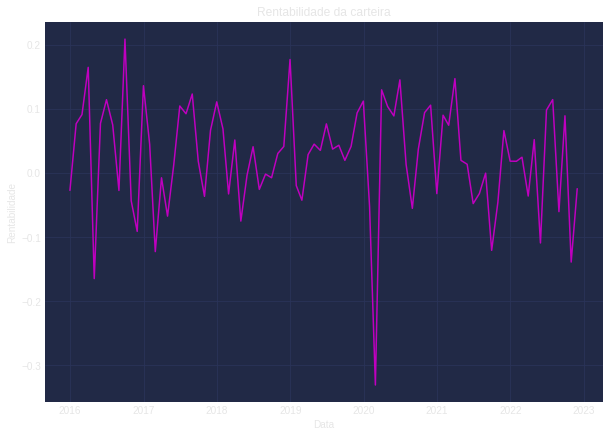

In [13]:
plt.style.use('cyberpunk')
plt.figure(figsize = [10,7])
plt.title('Rentabilidade da carteira')
plt.plot(retorno_modelo,'m-') # N° max visto na simulacao
plt.xlabel('Data')
plt.ylabel('Rentabilidade')
plt.show()

In [49]:
#Calcular a rentabilidade do ibovespa para comparar

ibovespa = yf.download("^BVSP", start = "2015-12-30", end="2022-12-31")['Adj Close']
ibovespa = ibovespa.resample("M").last().pct_change().dropna()
ibovespa = pd.DataFrame(ibovespa)
ibovespa.columns = ['Rentabilidade']
ibovespa

[*********************100%***********************]  1 of 1 completed


,Rentabilidade
Date,
2016-01-31,-0.067912
2016-02-29,0.059100
2016-03-31,0.169673
2016-04-30,0.077035
2016-05-31,-0.100889
...,...
2022-08-31,0.061629
2022-09-30,0.004693
2022-10-31,0.054527


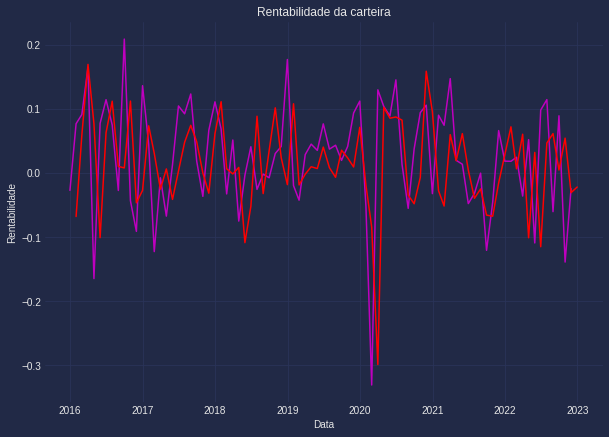

In [50]:
plt.style.use('cyberpunk')
plt.figure(figsize = [10,7])
plt.title('Rentabilidade da carteira')
plt.plot(retorno_modelo,'m-') # N° max visto na simulacao
plt.plot(ibovespa,'r-')
plt.xlabel('Data')
plt.ylabel('Rentabilidade')
plt.show()

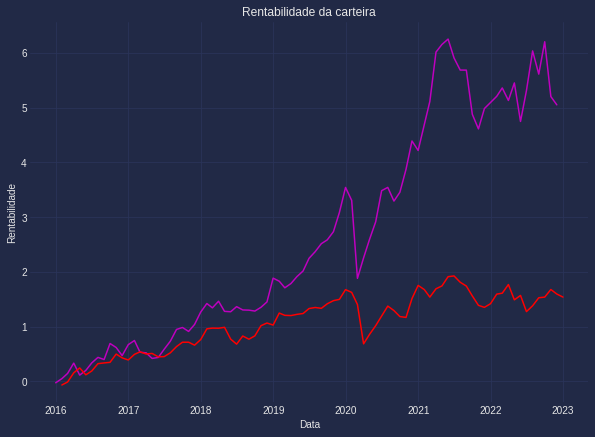

In [51]:
#Falta calcular retorno acumulado
retorno_Acum_modelo = (1 + retorno_modelo).cumprod() - 1
retorno_Acum_ibov = (1 + ibovespa).cumprod() - 1

plt.style.use('cyberpunk')
plt.figure(figsize = [10,7])
plt.title('Rentabilidade da carteira')
plt.plot(retorno_Acum_modelo,'m-') # N° max visto na simulacao
plt.plot(retorno_Acum_ibov,'r-')
plt.xlabel('Data')
plt.ylabel('Rentabilidade')
plt.show()

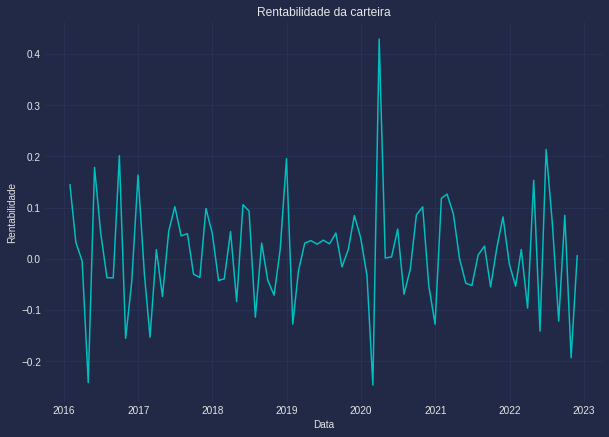

In [55]:
## Calculando a rentabilidade da carteira - ibovespa

ganhos_modelo = retorno_modelo - ibovespa

plt.figure(figsize = [10,7])
plt.title('Rentabilidade da carteira')
plt.plot(ganhos_modelo,'c-') # N° max visto na simulacao
plt.xlabel('Data')
plt.ylabel('Rentabilidade')
plt.show()

In [60]:
ganhos_modelo.describe()

,Rentabilidade
count,83.000000
mean,0.012006
std,0.104647
min,-0.246669
25%,-0.043542
50%,0.017763
75%,0.062839
max,0.428989


In [61]:
retorno_modelo.describe()

,Rentabilidade
count,84.000000
mean,0.025426
std,0.085355
min,-0.330959
25%,-0.028382
50%,0.032956
75%,0.089628
max,0.209198


In [63]:
retorno_Acum_modelo.describe()

,Rentabilidade
count,84.000000
mean,2.644945
std,1.990789
min,-0.027096
25%,0.938033
50%,1.963822
75%,4.703888
max,6.253117


In [64]:
ibovespa.describe()

,Rentabilidade
count,84.000000
mean,0.013625
std,0.069175
min,-0.299044
25%,-0.025659
50%,0.008572
75%,0.061571
max,0.169673
